# HW4: Bayesian Mixture Models


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Isaac

**Names of any collaborators:** Yan, Anmol

*Due: 11:59pm Monday, May 3, 2021 via GradeScope*

---

In this homework assignment we will investigate image segmentation ---specifically, separating the background from the foreground of the image. To do so, you'll learn Bayesian mixtures of Gaussians using Gibbs sampling.

### Background: Image Segmentation
The figure below shows the original input image and the resulting segmentations into background and foreground. By the end of this assignment, you will have implemented the algorithm to achieve this segmentation.

Reference on image segmentation: https://en.wikipedia.org/wiki/Image_segmentation

![Fox](images/fox_seg.png "Segmentation of fox image")


### Background: Non-Bayesian Mixtures

To set the stage, we begin with a straightforward finite mixture model to cluster the pixels (with the number of clusters $K = 2$ in our image segmentation problem). The likelihood of the model is defined as a mixture of Gaussian distributions.

$$
p(x_n \mid z_n, \{\mu_k, \Sigma_k\}_{k=1}^K) = \mathcal{N}(x_n; \mu_{z_n}, \Sigma_{z_n})
$$

where $x_n \in \mathbb{R}^D$ is distributed according to a Gaussian distribution with the specified mean, $\mu_k$, and covariance, $\Sigma_k$, for its correspondign cluster $z_n = k$. We will represent the images as a set of $N$ pixels, $\{x_n\}_{n=1}^N$, each in $D=3$ dimensional space, since there are three color channels (red, green, and blue).

### Bayesian Mixture

We specify the following priors on $\mu_k$, $\Sigma_k$, and $\pi$.
- Assume a normal-inverse-Wishart prior prior for each cluster mean and covariance.
\begin{align} 
p(\mu_k, \Sigma_k) &= \mathrm{IW}(\Sigma_k \mid \Psi_0, \nu_0) \, \mathcal{N}(\mu_k \mid m_0, \kappa_0^{-1} \Sigma_k)
\end{align}
Here $\Psi_0, \nu_0, m_0, \kappa_0$ are hyper-parameters.

- We give a symmetric Dirichlet distribution prior to the mixing proportions, $\pi$:
$$ 
p(\pi \mid \alpha) = \text{Dirichlet}(\alpha)
$$
with the hyper-parameter $\alpha$.

## Problem 1 [math]: posterior calculations
In this problem, you will derive the conditional posterior distributions of the various model parameters.

These are related to the joint posterior distribution:
$$
p(\pi, \{\mu_k, \Sigma_k\}_{k=1}^K, \{z_n\}_{n=1}^N \mid \{x_n\}_{n=1}^N, \alpha, \nu_0, \Psi_0, m_0, \kappa_0) 
\propto p(\pi \mid \alpha) \prod_{k=1}^K p(\mu_k, \Sigma_k \mid \nu_0, \Psi_0, m_0, \kappa_0) \prod_{n=1}^N p(z_n \mid \pi) p(x_n \mid \mu_{z_n}, \Sigma_{z_n})
$$


You will need these derivations to be correct for the implementation in Problem 2 to be correct, so we highly recommend taking the time to double check them.

### (a) Derive the complete conditional for the parameters $\mu_k, \Sigma_k$.
It should be a normal-inverse-Wishart distribution, like the prior.

The conditional distributions for $z_n$ and $\pi$ are the same as shown in lecture (note here $p=3$).

\begin{align*}
\mathcal{L}
&\propto
\bigg(
\prod_{i=1}^{N} |\Sigma_{z_i}|^{-1/2} 
\exp[-\frac{1}{2}(x_i - \mu_{z_i})^T\Sigma_{z_i}^{-1}(x_i - \mu_{z_i})]
\pi_{z_i}
\bigg) \\
&\hspace{1cm}
\bigg(
\prod_{k=1}^{K} |\kappa_0^{-1} \Sigma_k|^{1/2} 
\exp[-\frac{1}{2}(\mu_k - m_0)^T \kappa_0 \Sigma_k^{-1}(\mu_k - m_0)] \\&\hspace{1cm}\;\;\;
%\mathrm{IW}(\Sigma_k \mid \Psi_0, \nu_0) 
|\Psi_0|^{\nu_0/2} |\Sigma_k|^{\frac{-(\nu_0 + p + 1}{2}}\exp\bigg(-\frac{1}{2}tr(\Psi_0 \Sigma_k^{-1})\bigg)
\pi_k^{\alpha_k - 1}
\bigg).
\end{align*}

Our full conditionals are then:

Just as before,
\begin{align*}
Pr(z_i = k | -) 
&\propto \pi_k \exp[-\frac{1}{2}(x_i - \mu_{z_k})^T\Sigma_{z_k}^{-1}(x_i - \mu_{z_k})] \\
& \implies \\
Pr(z_i = k | -) 
&=
 \frac{\pi_k|\Sigma_{z_k}|^{-1/2}\exp[-\frac{1}{2}(x_i - \mu_{z_k})^T\Sigma_{z_k}^{-1}(x_i - \mu_{z_k})]}{
\sum_{j=1}^K
\pi_j|\Sigma_{z_j}|^{-1/2}
\exp[-\frac{1}{2}(x_i - \mu_{z_j})^T\Sigma_{z_j}^{-1}(x_i - \mu_{z_j})]
}.
\end{align*}

For the dirichlet, we use the same logic as slides 4.22:

\begin{align*}
\pi
&\propto
\prod_{i=1}^N \pi_{z_i}
\prod_{k=1}^K \pi_k^{\alpha_k - 1} \\
&\propto 
\prod_{k=1}^K \pi_k^{\alpha_k - 1 + \sum_{i}^{N} \delta(z_i = k)} \\
&\propto
\prod_{k=1}^K \pi_k^{\alpha_k - 1 + N_k} \\
&\sim Dir(\alpha_k + N_k)
\end{align*}

Lastly, for the covariance, we drop everything not including the $\Sigma_k$ or $\mu_k$ terms, and begin to aggregate a la slides 4.20 (the key step is multiplying out the $\mu_k$ terms and then dropping constants):
\begin{align*}
\mu_k, \Sigma_k | - 
&\propto
|\Sigma_{k}|^{-n_k/2}|\Sigma_{k}|^{-1/2}|\Sigma_{k}|^{-(\nu_0 + p + 1)/2}
\exp\bigg(\bigg[\sum_{i: z_i = k} (x_i - \mu_k)^T\Sigma_k^{-1}(x_i - \mu_k)\bigg] + \\
&\hspace{7.5cm}
(\mu_k - m_0)^T \kappa_0 \Sigma_k^{-1} (\mu_k - m_0) + 
tr(\Psi_0 \Sigma_k^{-1})
\bigg) \\
%&\hspace{5.5cm}
%\exp\bigg(
%(\sum_{i:z_i = k} x_i))^T \Sigma_{k}^{-1} \mu_k - \frac{N_k}{2}\mu_k^T\Sigma_{k}^{-1}\mu_k +
%m_0^T\kappa_0 \Sigma_k^{-1} \mu_k - \frac{1}{2}\kappa_0\Sigma_k^{-1}\mu_k
%\bigg) \\
&\propto
|\Sigma_{k}|^{-(n_k + \nu_0 + p + 2)/2}
\exp\bigg(-\frac{1}{2}\bigg(
\bigg[n_k(\mu_k - \bar x_{i: z_i = k})^T \Sigma_k^{-1}(\mu_k - \bar x_{i: z_i = k}) + \\
&\hspace{5.5cm}
\sum_{i: z_i = k} (x_i - \bar x_{i: z_i = k})^T\Sigma_k^{-1}(x_i - \bar x_{i: z_i = k})
\bigg]  + \\
&\hspace{5.5cm}
(\mu_k - m_0)^T\kappa_0\Sigma_k^{-1}(\mu_k - m_0) +
tr(\Psi_0 \Sigma_k^{-1})
\bigg)\bigg) \\
&=
|\Sigma_{k}|^{-(n_k + \nu_0 + p + 2)/2}
\exp\bigg(-\frac{1}{2}\bigg(
\bigg[n_k(\mu_k - \bar x_{i: z_i = k})^T \Sigma_k^{-1}(\mu_k - \bar x_{i: z_i = k}) + 
(\mu_k - m_0)^T\kappa_0\Sigma_k^{-1}(\mu_k - m_0)
\bigg]  + \\
&\hspace{5.5cm} +
tr(\Psi_0 \Sigma_k^{-1}) + \sum_{i: z_i = k} (x_i - \bar x_{i: z_i = k})^T\Sigma_k^{-1}(x_i - \bar x_{i: z_i = k})
\bigg)\bigg) \\
&=
|\Sigma_{k}|^{-(n_k + \nu_0 + p + 2)/2}
\exp\bigg(-\frac{1}{2}\bigg(
\bigg[n_k(\mu_k - \bar x_{i: z_i = k})^T \Sigma_k^{-1}(\mu_k - \bar x_{i: z_i = k}) + 
(\mu_k - m_0)^T\kappa_0\Sigma_k^{-1}(\mu_k - m_0)
\bigg]  + \\
&\hspace{5.5cm} +
tr(\Psi_0 \Sigma_k^{-1}) + (\sum_{i: z_i = k} tr(x_i - \bar x_{i: z_i = k})(x_i - \bar x_{i: z_i = k})^T\Sigma_k^{-1})
\bigg)\bigg) \\
\end{align*}
As given by lectures 1-2, this is a Normal-Inverse-Wishart kernel, one 
\begin{align*}
NIW\bigg(&\mu = (n_k\bar x_{i: z_i = k} + m_0\kappa_0)(n_k + \kappa_0)^{-1} \\
&\kappa=\kappa_0 + n_k \\
&\nu = n_k + \nu_0 \\
& \Psi_0 + \sum_{i: z_i = k} (x_i - \bar x_{i: z_i = k})(x_i - \bar x_{i: z_i = k})^T + 
(m_0 - \bar x_{i: z_i = k})(m_0 - \bar x_{i: z_i = k})^T \frac{\kappa_0 n_k}{\kappa_0 + n_k}
\bigg)
\end{align*}
This final step is most easily verified (it's not intuitive) by cheating: plug the parameters into the NIW distribution, begin to distribute and rearrange terms, and you achieve the kernel noted above.






## Problem 2: Gibbs Sampler
We have provided starter code below.
- First, you need to fill it with your own implementation of the Gibbs sampling algorithm. You may not rely on external implementations such as those offered by Tensorflow or scikit-learn.
- Then, you will test your code on a simple example.

### (a) Implement the Gibbs Sampler 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import itertools
from scipy.stats import (
    multivariate_normal, 
    norm, 
    dirichlet, 
    invwishart, 
    bernoulli
)
mvn = multivariate_normal

def normal_inv_wishart(u, k, v, psi):
    sig = invwishart(df=v + 1 + psi.shape[0], scale=psi).rvs()
    mu = mvn(u, sig/k).rvs()
    return mu, sig

class GibbsMixture:
    """
    Class to store information for Gibbs sampler
    """
    def __init__(self,
                 K=2, 
                 alpha=np.ones(2), 
                 m0=np.zeros(3), 
                 kappa0=1.0, 
                 nu0=1.0,
                 Psi0=np.eye(3)):
        # init hyperparams
        self.K=K
        self.alpha=alpha
        self.m0=m0
        self.k0=kappa0
        self.nu0=nu0
        self.Psi0=Psi0
        
        self.N=None
        self.Nk=None
        self.z=None
        self.X=None
        self.u_k=None
        self.Sigma_k=None
        self.pi=None
        
    def construct(self, X, seed=2020, init_mean=True):
        # store data
        self.X=X
        self.N=X.shape[0]
        self.D=X.shape[1]
        
        # initialize state values
        np.random.seed(seed)
        self.z=np.random.choice(2, self.N)
        self.Nk = {k: np.sum(self.z == k) for k in range(self.K)}
        if init_mean:
            self.u_k=mvn(X.mean(axis=0), np.eye(self.D)).\
                rvs(self.K, random_state=seed).\
                reshape((self.K, self.D))
        else:
            self.u_k = np.zeros((self.K, self.D))
        self.Sigma_k = np.stack([
            np.eye(self.D) for i in range(self.K)
        ])
        self.pi = dirichlet(self.alpha).rvs()[0]
        
        # logs
        self.z_log = []
        self.u_k_log = []
        self.pi_log = []
        self.Sigma_k_log = []
        self.log_loss_log = []
        
    def lpdf(self, X):
        logpdf = 0
        for k in range(self.K):
            k_idx = np.where(self.z == k)[0] 
            logpdf += (self.alpha[k] + self.Nk[k]) * np.log(self.pi[k])+ \
                np.sum(mvn(self.u_k[k, :], self.Sigma_k[k, :, :]/self.k0).logpdf(X[k_idx, :])) + \
                mvn(self.m0, self.Sigma_k[k, :, :]).logpdf(self.u_k[k, :]) + \
                invwishart(self.nu0 + 1 + self.Psi0.shape[0], self.Psi0).logpdf(self.Sigma_k[k, :, :])
        return logpdf
        
    def recount_nk(self):
        self.Nk = {k: np.sum(self.z == k) for k in range(self.K)}
        
    def update_z(self):
        probs = np.vstack([self.pi[k] * mvn(self.u_k[k, :], self.Sigma_k[k, :, :]).pdf(self.X)
                           for k in range(self.K)])
        denoms = probs.sum(axis=0)
        for k in range(self.K):
            probs[k, :] = np.divide(probs[k, :], denoms)
        self.z = bernoulli(p=probs[1, :]).rvs(self.N)
        self.recount_nk()
        
    def update_pi(self):
        alpha_ = np.add(self.alpha, np.array(list(self.Nk.values())))
        self.pi = dirichlet(alpha_).rvs()[0]
        
    def update_musig(self):
        for k in range(self.K):
            nk = self.Nk[k]
            k_idx = np.where(self.z == k)[0]
            u_ = np.add(nk * self.X[k_idx, :].mean(axis=0), self.m0 * self.k0) /\
                (nk + self.k0)
            k_ = self.k0 + nk
            v_ = self.nu0 + nk + 1
            sse_kindof = self.X[k_idx, :] - self.X[k_idx, :].mean(axis=0)
            sse_prior = self.m0 - self.X[k_idx, :].mean(axis=0)
            psi_ = np.add(
                np.add(self.Psi0, sse_kindof.T.dot(sse_kindof)),
                (self.k0 * nk)/(self.k0 + nk) * np.outer(sse_prior, sse_prior)
            )
            mu, sig = normal_inv_wishart(u_, k_, v_, psi_)
            self.Sigma_k[k, :, :] = sig
            self.u_k[k, :] = mu
            
    def update(self):
        
        self.update_pi()
        self.update_z()
        self.update_musig()
        
        self.z_log.append(np.copy(self.z))
        self.pi_log.append(np.copy(self.pi))
        self.u_k_log.append(np.copy(self.u_k))
        self.Sigma_k_log.append(np.copy(self.Sigma_k))
        
        self.log_loss_log.append(self.lpdf(self.X))
        
    def sample(self, n_iter=1000):
        self.z_log.append(self.z)
        self.pi_log.append(self.pi)
        self.u_k_log.append(self.u_k)
        self.Sigma_k_log.append(self.Sigma_k)
        
        vfun = tqdm # lambda x: x 
        # vfun = lambda x: x
        for _ in vfun(range(n_iter)):
            self.update()
        self.u_k_log = np.stack(self.u_k_log)
        self.z_log = np.stack(self.z_log)
        self.pi_log = np.stack(self.pi_log)
        self.Sigma_k_log = np.stack(self.Sigma_k_log)
            
    def trace_mu(self, burnin=100):
        fig, ax = plt.subplots(2, 3)
        ax[0, 0].plot(self.u_k_log[burnin:, 0, 0], label='u_{0, 0}')
        ax[0, 0].legend()
        ax[0, 1].plot(self.u_k_log[burnin:, 0, 1], label='u_{0, 1}')
        ax[0, 1].legend()
        ax[0, 2].plot(self.u_k_log[burnin:, 0, 2], label='u_{0, 2}')
        ax[0, 2].legend()
        ax[1, 0].plot(self.u_k_log[burnin:, 1, 0], label='u_{1, 0}')
        ax[1, 0].legend()
        ax[1, 1].plot(self.u_k_log[burnin:, 1, 1], label='u_{1, 1}')
        ax[1, 1].legend()
        ax[1, 2].plot(self.u_k_log[burnin:, 1, 2], label='u_{1, 2}')
        ax[1, 2].legend()
        plt.show() 
        
    def trace_log_loss(self):
        plt.plot(self.log_loss_log)
        plt.xlabel('Iteration')
        plt.ylabel('Log Density')
        plt.title('Log Density Trace')
        plt.show()
        
    def trace_marginal_mu(self, burnin=0):
        for k, p in itertools.product(range(self.K), range(self.D)):
            sns.kdeplot(self.u_k_log[burnin:, k, p], label = f"u({k}, {p})")
        plt.legend()
        plt.show()
        
def gibbs(X, 
          K=2, 
          n_iter=100, 
          alpha=np.ones(2), 
          m0=np.zeros(3), 
          kappa0=1.0, 
          nu0=1.0, 
          Psi0=np.eye(3)):
    """
    Run the Gibbs samlper for a mixture of Gaussians with a NIW prior.
    
    Input:
    - X: Matrix of size (N, D). Each row of X stores one data point
    - K: the desired number of clusters in the model. Default: 2
    - n_iter: number of iterations of Gibbs sampling. Default: 100
    - alpha: hyperparameter of the Dirichlet prior on \pi.
    - m0, kappa0, nu0, Psi0, hyperparameters of normal-inverse-Wishart prior.
        
    Returns: 
    - log joint probability for each iteration
    - samples of parameters and assignments over iterations
    
    You will use these values later on for convergence diagnostics.
    """
    
    sampler = GibbsMixture(K=K, alpha=alpha, m0=m0, kappa0=kappa0, nu0=nu0)
    sampler.construct(X)
    sampler.sample(n_iter=n_iter)
    return sampler


def full_picture_suite(X, n_iter=1000, plot=True, **kwargs):
    sampler=GibbsMixture()
    sampler.construct(X, **kwargs)
    sampler.sample(n_iter=n_iter)
    if plot:
        sampler.trace_mu()
        sampler.trace_log_loss()
        sampler.trace_marginal_mu()
        print(f"Pct. Category 1: {np.mean(sampler.z)}" )
    return sampler

### (b) test your implementation 
Test your example on a synthetic data set.

For example, the ground truth could be two clusters, with means [5,5,5] and [8,8,8] respectively. You could generate $50$ points in each cluster. 

Whichever example you choose, be sure to specify it and show that your implementation roughly recovers the ground truth by displaying the cluster means/covariances and trace plots of the log joint probability.

100%|██████████| 2000/2000 [00:12<00:00, 156.50it/s]


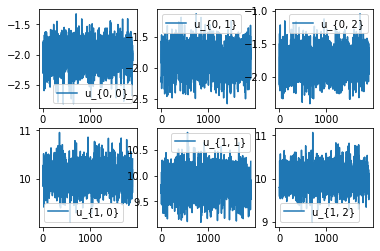

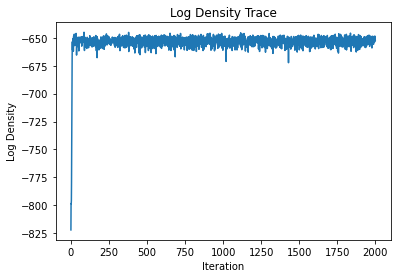

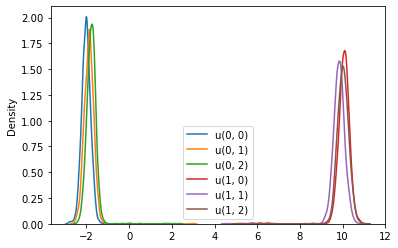

Pct. Category 1: 0.5


In [2]:
X_syn = np.vstack([
    multivariate_normal([-2, -2, -2], 2 * np.eye(3)).rvs(50),
    multivariate_normal([10, 10, 10], np.eye(3)).rvs(50)
])

_ = full_picture_suite(X_syn, n_iter=2000)

Our synthetic data consists of 50 draws from $N(\vec{-2}, I_3)$ for one class and 50 draws from $N(\vec{10}, I_3)$. As the trace and histograms show, we appear to recover the correct clusters; further, half of all assignments are to C1 and half to C2, suggesting the Gibbs is functioning properly. 

## Problem 3 : Perform image segmentation
Now that you have implemented the Gibbs Sampler, you are ready to perform image segmentation!
First, we define helper code to load the images and save the segmentation.

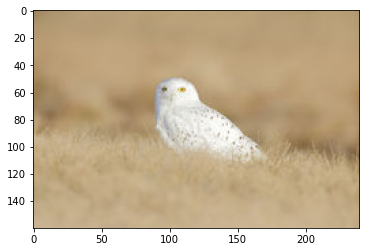

In [3]:
def load_image(filename):
    # Read in the image, dropping the alpha channel
    image = plt.imread(filename + ".png")[:, :, :3]
    plt.imshow(image)

    # get height, width and number of channels
    H, W, C = image.shape
    X = image.copy().astype(float)

    # reshape into pixels, each has 3 channels (RGB)
    X = X.reshape((H * W, C)) 
    return image, X

def save_segmentation(image, assignments, K=1, filename=None):
    fig, axs = plt.subplots(1, K + 1, figsize=(4 * (K + 1), 4))
    axs[0].imshow(image)
    axs[0].set_axis_off()
    axs[0].set_title("original image")
    
    H, W, C = image.shape
    assign_ = assignments.reshape((H, W))
    
    for k in range(K):
        im = image.copy()
        im[assign_ != k] = np.nan
        axs[k+1].imshow(im)
        axs[k+1].set_axis_off()
        axs[k+1].set_title("component {}".format(k))
    
    if filename is not None:
        plt.savefig(filename)
        
zebra, X_zebra = load_image('/Users/isaac.kleisle-murphy/Downloads/zebra')
cow, X_cow = load_image('/Users/isaac.kleisle-murphy/Downloads/cow')
fox, X_fox = load_image('/Users/isaac.kleisle-murphy/Downloads/fox')
owl, X_owl = load_image('/Users/isaac.kleisle-murphy/Downloads/owl')

#### Run the Gibbs sampler
Run the Gibbs sampler on the 4 provided images: "cow", "fox", "owl", "zebra". The hyper-parameters values should be the default ones from the Gibbs function.

Each sample of $\{z_n\}_{n=1}^N$ is a segmentation. To aggregate them into one sample, you could assign each pixel to the component it was most often attributed to in your samples.

### Zebra 1.0

First, we run the Gibbs sampler on the zebra, initialising cluster centers about the mean of $x_i$. Trace plots and diagnostics are provided below. *Note that for the trace plots -- but not the log loss plots -- I drop the first 100 samples to better evaluate mixing. That is, the log loss plots report log loss from iterations 0 to 2000, but the trace plots report mixing from 100-2000.*

100%|██████████| 2000/2000 [05:59<00:00,  5.56it/s]


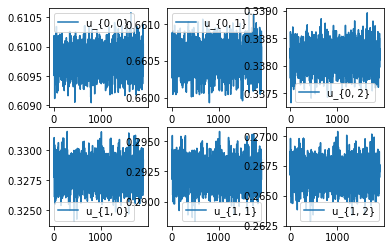

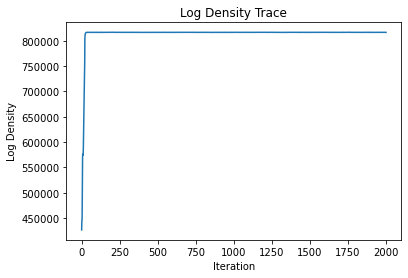

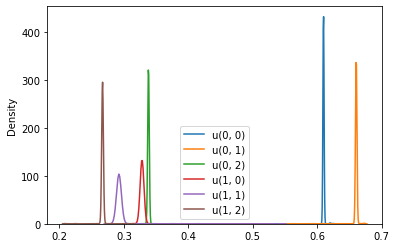

Pct. Category 1: 0.3202604680394194


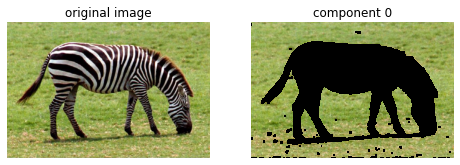

In [13]:
zebra1 = full_picture_suite(X_zebra, n_iter=2000)

save_segmentation(
    zebra, 
    assignments=np.round((zebra1.z_log.mean(axis=0))),
    filename=None
)

### Cow 1.0

Second, we run the Gibbs sampler on the cow, initialising cluster centers about the mean of $x_i$. Trace plots and diagnostics are provided below.

100%|██████████| 2000/2000 [01:16<00:00, 26.07it/s]


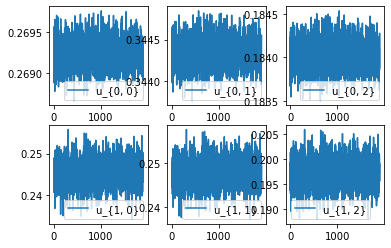

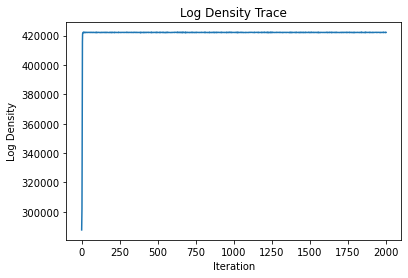

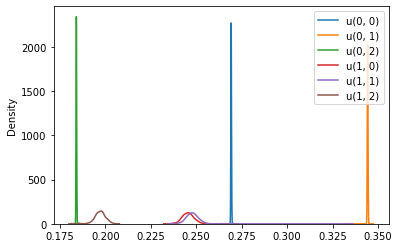

Pct. Category 1: 0.11836734693877551


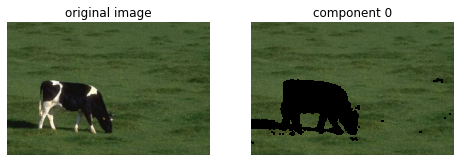

In [5]:
cow1 = full_picture_suite(X_cow, n_iter=2000)

save_segmentation(
    cow, 
    assignments=np.round((cow1.z_log.mean(axis=0))),
    filename=None
)

### Fox 1.0

Third, we run the Gibbs sampler on the fox, initialising cluster centers about the mean of $x_i$. Trace plots and diagnostics are provided below.

100%|██████████| 2000/2000 [08:09<00:00,  4.08it/s]


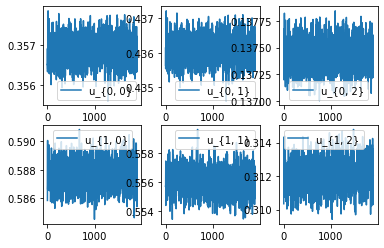

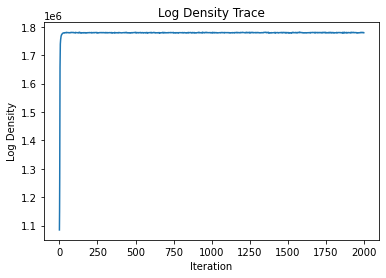

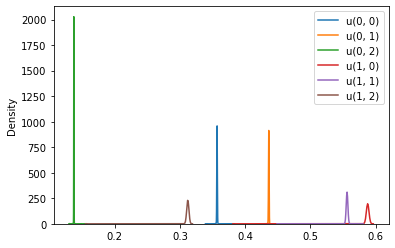

Pct. Category 1: 0.12188904494382022


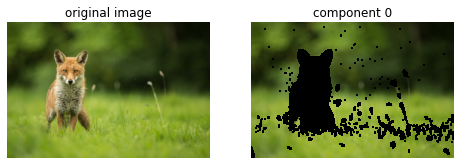

In [6]:
fox1 = full_picture_suite(X_fox, n_iter=2000)

save_segmentation(
    fox, 
    assignments=np.round((fox1.z_log.mean(axis=0))),
    filename=None
)

### Owl 1.0

Fourth, we run the Gibbs sampler on the owl, initialising cluster centers about the mean of $x_i$. Trace plots and diagnostics are provided below.

100%|██████████| 2000/2000 [00:45<00:00, 44.39it/s]


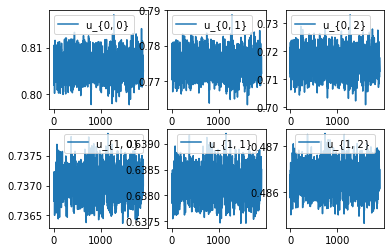

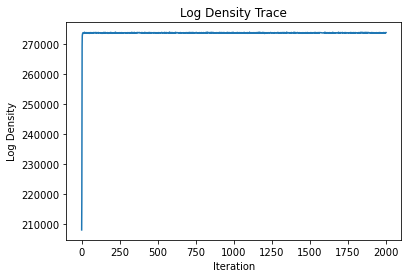

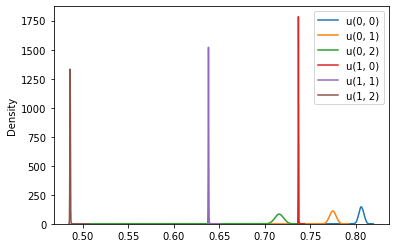

Pct. Category 1: 0.9054947916666667


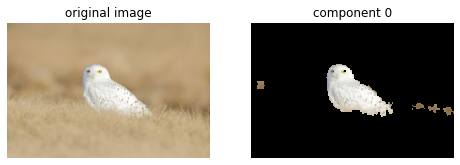

In [7]:
owl1 = full_picture_suite(X_owl, n_iter=2000)

save_segmentation(
    owl, 
    assignments=np.round((owl1.z_log.mean(axis=0))),
    filename=None
)

## Problem 4: Diagnostics
### (a)
Make trace plots of the log joint probability and posterior marginals of the cluster means (e.g. as histograms for R, G, and B weights.)

These trace plots are provided above

### (b)
(Approximately) how many iterations are needed for convergence? Does this depend on the input image and/or initialization of the model parameters?

When initializing clusters to the mean of the $x$'s, we see pretty quick convergence -- almost always less than 50iterations. That's pretty good, let's see what happens when we initialize the clusters straight to zero, rather than the means.

### Cow 2.0:
For the cow:

100%|██████████| 2000/2000 [01:04<00:00, 31.25it/s]


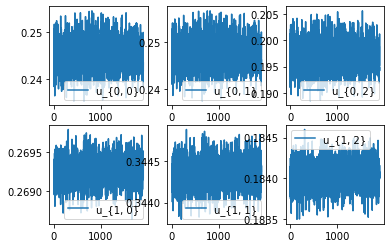

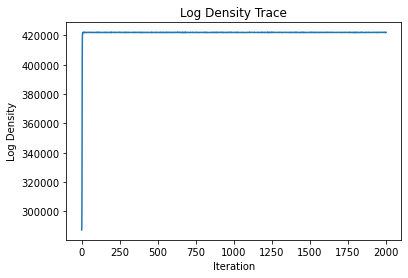

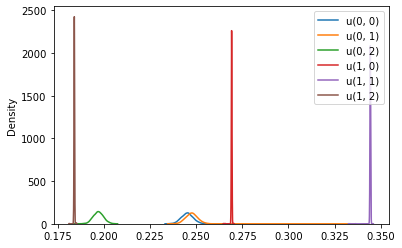

Pct. Category 1: 0.8814455782312925


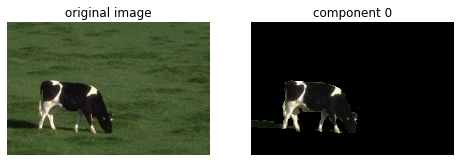

In [8]:
cow2 = full_picture_suite(X_cow, n_iter=2000, init_mean=False)
save_segmentation(
    cow, 
    assignments=np.round((cow2.z_log.mean(axis=0))),
    filename=None
)

### Fox 2.0:
For the fox:

100%|██████████| 2000/2000 [07:21<00:00,  4.53it/s]


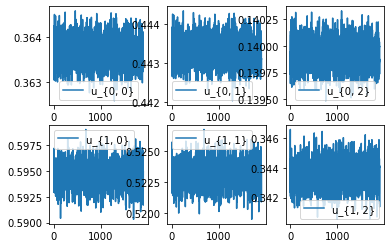

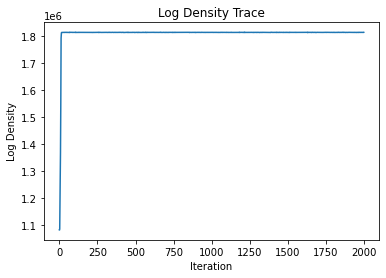

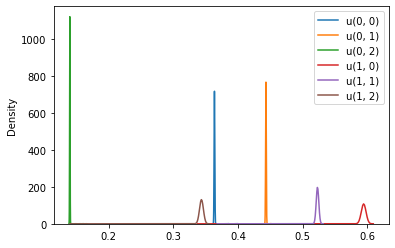

Pct. Category 1: 0.09177902621722847


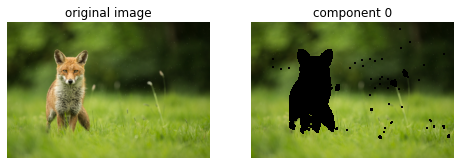

In [9]:
fox2 = full_picture_suite(X_fox, n_iter=2000, init_mean=False)
save_segmentation(
    fox, 
    assignments=np.round((fox2.z_log.mean(axis=0))),
    filename=None
)

### Owl 2.0:
For the owl:

100%|██████████| 2000/2000 [00:44<00:00, 45.19it/s]


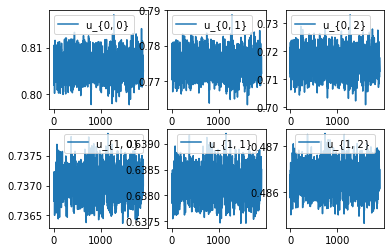

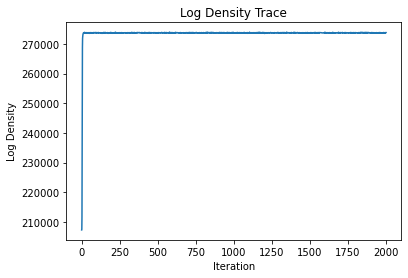

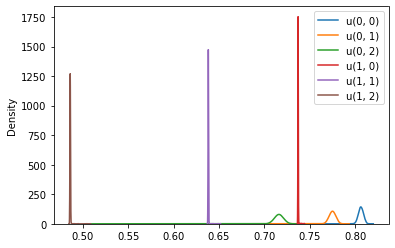

Pct. Category 1: 0.9054947916666667


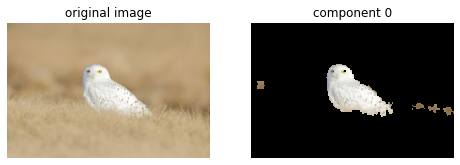

In [10]:
owl2 = full_picture_suite(X_owl, n_iter=2000, init_mean=False)
save_segmentation(
    owl, 
    assignments=np.round((owl2.z_log.mean(axis=0))),
    filename=None
)

### Zebra 2.0
And for the zebra:

100%|██████████| 2000/2000 [04:03<00:00,  8.21it/s]


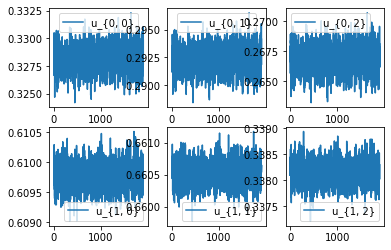

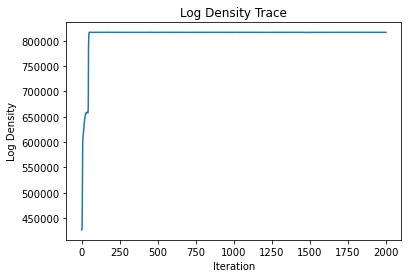

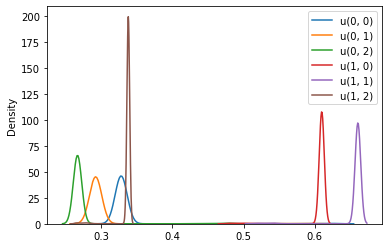

Pct. Category 1: 0.6795693199375016


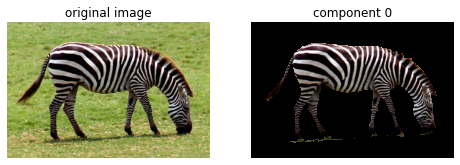

In [11]:
zebra2 = full_picture_suite(X_zebra, n_iter=2000, init_mean=False)
save_segmentation(
    zebra, 
    assignments=np.round((zebra2.z_log.mean(axis=0))),
    filename=None
)

By the looks of things, initialising the cluster means at zero, rather than the overall means, does not impede convergence too much: for the fox, owl, and cow, the modely quickly (<50 iterations again) finds near-convergent losses. We do, however, see it impede the zebra's convergence a touch (~100 iterations). Note the small chicane in the convergence trace for the zebra, which reflects comparatively slower convergence than the mean initialisation. However, the sampler has little difficulty converging, so this difference is small peanuts. Of course, if we initialised the sampler at something totally unreasonable -- i.e. $\langle -55, -55, -55\rangle$ for both clusters -- convergence may take much longer. In fact, if initalisation was so unreasonable as to result in completely imbalanced (i.e. 0 for one group, 100 for the other) group assignments, our code could quickly become stuck. On top of the numeric instability issues induced by such a scheme, $\alpha=1$ priors would be inundated by the class assignments $N_k$ when drawing $\pi$, which might preclude the sampler from ever rebalancing the groups. 

## Problem 5: Extensions

### (a) Sample the posterior predictive distribution to get a new image

In order to have a posterior, and in turn, posterior predictive from which to sample, we first need data. So we'll recycle our cow as our data (our "X"), sample the posterior given this $X$, and then generate a new image from this posterior predictive (We'll also recycle our posterior draws from the cow from Problem 3, as we have those on hand).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


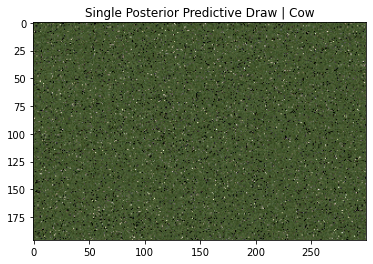

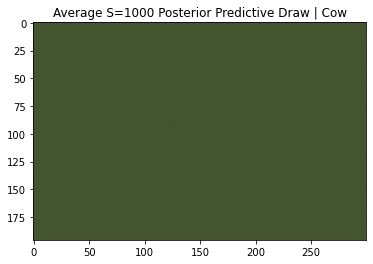

In [14]:
def posterior_predictive_draw(pp_fit, M=1):
    result = []
    for i in range(M):
        S = pp_fit.X.shape[0]
        np.random.seed(i)
        pp_idx = np.random.choice(range(100, pp_fit.u_k_log.shape[0]))



        # get posterior predictive params
        pp_pi = pp_fit.pi_log[pp_idx, :]
        pp_u_k = pp_fit.u_k_log[pp_idx, :, :]
        pp_Sigma_k = pp_fit.Sigma_k_log[pp_idx, :, :, :]
        # draw the classes
        pp_z = bernoulli(pp_pi[1]).rvs(S, random_state=124)
        img_0 = mvn(pp_u_k[0, :], pp_Sigma_k[0, :, :]).rvs(S - np.sum(pp_z))
        img_1 = mvn(pp_u_k[1, :], pp_Sigma_k[1, :, :]).rvs(np.sum(pp_z))
        img = np.vstack([img_0, img_1])[np.random.choice(S, S, replace=False), :]
        result.append(img)
    result = np.stack(result)
    return result

single_image = posterior_predictive_draw(cow1)
plt.imshow(single_image[0, :, :].reshape(cow.shape))
plt.title('Single Posterior Predictive Draw | Cow')
plt.show()

multi_image = posterior_predictive_draw(cow1, 1000)
plt.imshow(multi_image.mean(axis=0).reshape(cow.shape))
plt.title('Average S=1000 Posterior Predictive Draw | Cow')
plt.show()

Here's our first image(s) (the first, a single posterior predictive draw, and the second, 1000 posterior predictive draws averaged), as sampled from the cow -- as expected, total nonsense!

Alternatively, we could also generate an $X$ (to build the posterior off of) from our generative distribution. This would amount to (we'll make it the same shape as the cow, for continuity). First we plot the generated image, as well as the diagnostics for the posterior sampled from it. 

100%|██████████| 2000/2000 [01:12<00:00, 27.40it/s]


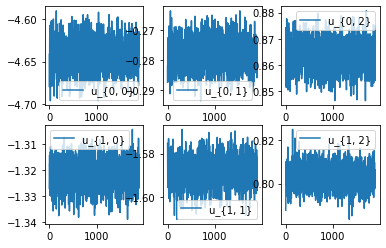

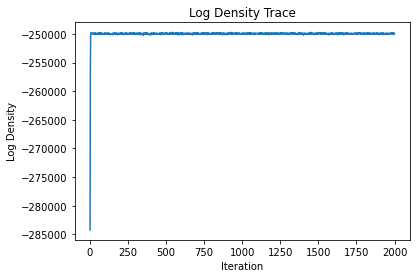

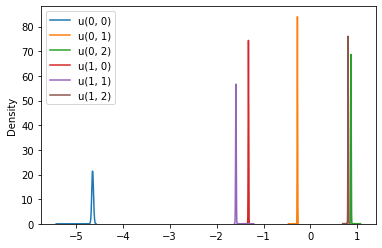

Pct. Category 1: 0.49984693877551023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


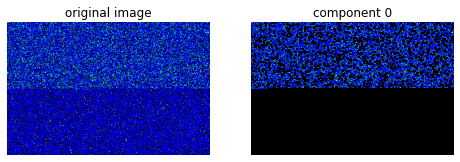

In [15]:
## a.)
# make a cow-shaped dataset from the generative model
S = X_cow.shape[0]
sigma_k = invwishart(1 + 3 + 1, np.eye(3)).rvs(2, random_state=123)
u_k = np.stack([mvn(np.zeros(3), sigma_k[k, :, :]).rvs(random_state=k) for k in range(2)])
cat_props = dirichlet([1, 1]).rvs(S, random_state=123)
z = bernoulli(cat_props[:, 1]).rvs(S, random_state=123)
X_gen = np.vstack([
    mvn(u_k[0, :], sigma_k[0, :, :]).rvs(S - np.sum(z), random_state=123),
    mvn(u_k[1, :], sigma_k[1, :, :]).rvs(np.sum(z), random_state=321)
])

synthetic = full_picture_suite(X_gen, n_iter=2000)

save_segmentation(
    X_gen.reshape(cow.shape), 
    assignments=np.round((synthetic.z_log.mean(axis=0))),
    filename=None
)

Above, we have our generated ("X") shape, and the posterior segmentation on that shape. Now, with these posterior fits/parameter samples, let's draw the posterior image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


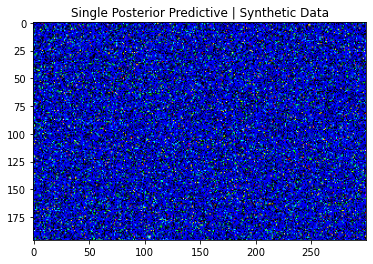

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


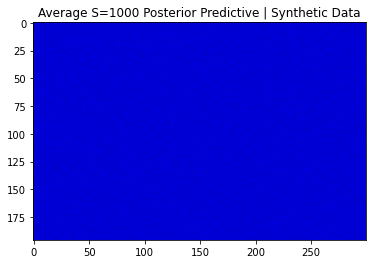

In [16]:
single_image = posterior_predictive_draw(synthetic)
plt.imshow(single_image[0, :, :].reshape(cow.shape))
plt.title('Single Posterior Predictive | Synthetic Data')
plt.show()

multi_image = posterior_predictive_draw(synthetic, 1000)
plt.imshow(multi_image.mean(axis=0).reshape(cow.shape))
plt.title('Average S=1000 Posterior Predictive | Synthetic Data')
plt.show()

Again, equally silly.

### (b) Improvements to the model
The generated images should not look realistic. Explain why that is the case: suggest improvements to the generative model that would make for more realistic samples.
You do not need to implement the change though.

One issue with the generative model might be it's vanilla-ness: priors on segments are equally likely (Dirichlet prior), while all clusters have the prior belief of being the same. In this way, when we sample from the generative model to build our data, we're really just sloshing paint onto a canvas without any rhyme or reason. One way to improve this might be to adapt the generative model to reflect some existing picture. For instance, if we have empirical knowledge of segmentation values/probabilities and cluster values from a previous study, we might use those as a prior. In this way, we'd generate our data closer to something that is an actual image, and perhaps get a better result. 

I'd also add that, more broadly, the generative model does not take into account pixel location explicitly. A lighter pixel towards the boundary may mean something different than a lighter pixel in the middle. This might alleviate the scattershot tendencies of the posterior predictives above. Likewise, the covariance structure between adjacent pixels is not robust -- other than the class label, there's not much else passed to the model about the nature of the surrounding pixels.

Finally, we only do two classes here. This problem could certainly be worth a try with $K > 2$. 

### (c) Label switching
What could go wrong with the proposed method of deriving segmentations in problem 3? 

One issue is interpretability: the naming of the segments is completely arbitrary. Consider the difference between segmentations in problems 3/4 for the cow. On our first run (mean initialisation), the sampler assigned the cow itself to group 1; however, on the second (zero initialisation), the sampler assigned everything but the cow to group 1. In this way, it was separating the same components each time, but assigned different label names to each. In this way, the definition "label 0" is meaningless/not very interpretable, as it does not reflect the cow specifically. For some samplers, it maybe the not-cow, but for others it maybe the cow. 

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw4_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 